## Import Libraries

In [1]:
from quspin.operators import hamiltonian
from quspin.basis import spin_basis_1d
from quspin.basis import spinless_fermion_basis_1d
import numpy as np
import matplotlib.pyplot as plt
import itertools
plt.rcParams['figure.figsize'] = [10, 8]

## Define Constants/Helpers

In [2]:
N_group = 2
N = 10
N_filled = N // 2
P_neg1 = 1
t = -0.5
g = 1
m = 1
PBC = True

In [3]:
def stringbox(lst, caption):
    return caption + "-" * (100 - len(caption))+"\n" + str(lst) + "\n" + "-" * 100

## Spin Basis Simulation

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


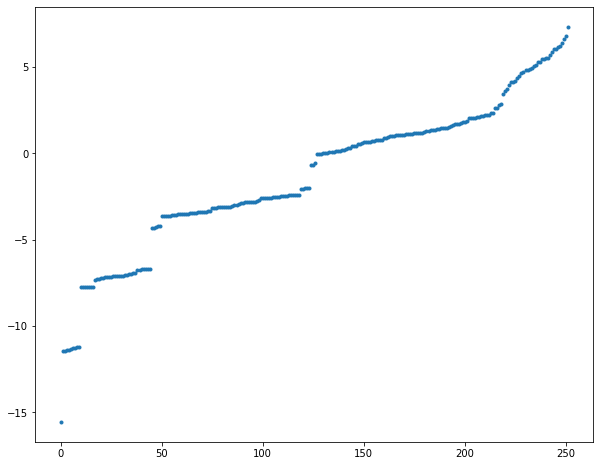

In [7]:
spin_basis = spin_basis_1d(N, pauli=-1, Nup=N_filled)
static_terms = []
dynamic_terms = []

### Hopping term
L = (N if PBC else N-1)
hop_coupling = [[-t, i, (i+1) % N] for i in range(L)]
hop_coupling_dag = [[-t, (i+1) % N, i] for i in range(L)]
if PBC and N_filled % 2 == 0:
    hop_coupling[-1][0] = -hop_coupling[-1][0]
    hop_coupling_dag[-1][0] = -hop_coupling_dag[-1][0]
static_terms += [["+-", hop_coupling]]
static_terms += [["+-", hop_coupling_dag]]

### Mass term
mass_coupling = [[m * (-1) ** i, i, i] for i in range(N)]
static_terms += [["+-", mass_coupling]]

### E-field term
def powerset(seq):
    if len(seq) == 1:
        yield seq
    else:
        for item in powerset(seq[1:]):
            yield [seq[0]]+item
            yield item
def P(n, dag=False):
    i_parity = (-1 if dag else 1)
    phase = np.exp(1j * (1 - n % 2) * np.pi / N_group * i_parity)
    P_coupling = []
    for seq in powerset(list(range(n + 1))):
        seq = list(seq)
        coupling = np.cos(np.pi / N_group)**(n - len(seq) + 1) * (np.sin(np.pi / N_group) * i_parity * 1j)**len(seq)
        coupling *= P_neg1 * -g * phase * 0.5
        couple_list = [coupling] + seq
        P_coupling += [["z" * len(seq)] + [[couple_list]]]
    return P_coupling
    
for i in range(N):
    static_terms += P(i, dag=False)
    static_terms += P(i, dag=True)

# This list is annoyingly long
# print(stringbox(static_terms, "Static couplings:"))
### Plotting spectrum
H = hamiltonian(static_terms, dynamic_terms, basis=spin_basis, dtype=np.complex64)
spin_eigvals = H.eigvalsh()
plt.plot(spin_eigvals, ".")
plt.show()

## Fermion Basis

Static couplings:-----------------------------------------------------------------------------------
[['+-', [[0.5, 0, 1], [0.5, 1, 2], [0.5, 2, 3], [0.5, 3, 4], [0.5, 4, 5], [0.5, 5, 6], [0.5, 6, 7], [0.5, 7, 8], [0.5, 8, 9], [0.5, 9, 0]]], ['+-', [[0.5, 1, 0], [0.5, 2, 1], [0.5, 3, 2], [0.5, 4, 3], [0.5, 5, 4], [0.5, 6, 5], [0.5, 7, 6], [0.5, 8, 7], [0.5, 9, 8], [0.5, 0, 9]]], ['+-', [[1, 0, 0], [-1, 1, 1], [1, 2, 2], [-1, 3, 3], [1, 4, 4], [-1, 5, 5], [1, 6, 6], [-1, 7, 7], [1, 8, 8], [-1, 9, 9]]], ['z', [[2, 0]]], ['zz', [[4, 0, 1]]], ['zzz', [[-8, 0, 1, 2]]], ['zzzz', [[-16, 0, 1, 2, 3]]], ['zzzzz', [[32, 0, 1, 2, 3, 4]]], ['zzzzzz', [[64, 0, 1, 2, 3, 4, 5]]], ['zzzzzzz', [[-128, 0, 1, 2, 3, 4, 5, 6]]], ['zzzzzzzz', [[-256, 0, 1, 2, 3, 4, 5, 6, 7]]], ['zzzzzzzzz', [[512, 0, 1, 2, 3, 4, 5, 6, 7, 8]]], ['zzzzzzzzzz', [[1024, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]]]
----------------------------------------------------------------------------------------------------
Hermiticity check passed!


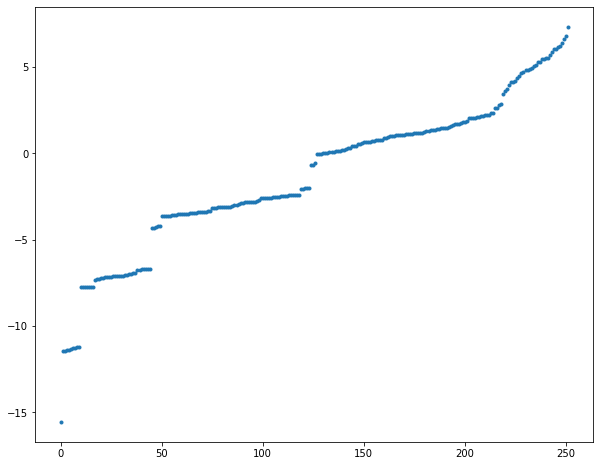

In [5]:
fermion_basis = spinless_fermion_basis_1d(L=N, Nf=N_filled)
static_terms = []
dynamic_terms = []

### Hopping term
L = (N if PBC else N-1)
hop_coupling = [[-t, i, (i+1) % N] for i in range(L)]
hop_coupling_dag = [[-t, (i+1) % N, i] for i in range(L)]
static_terms += [["+-", hop_coupling]]
static_terms += [["+-", hop_coupling_dag]]

### Mass term
mass_coupling = [[m * (-1) ** i, i, i] for i in range(N)]
static_terms += [["+-", mass_coupling]]

### E-field term
E_link_parity = lambda x : -1 if (x % 4) < 2 else 1
for i in range(N):
    E_coupling = [P_neg1 * -g * E_link_parity(i) * 2 ** (i+1)] + list(range(i+1))
    static_terms += [["z" * (i+1), [E_coupling]]]

print(stringbox(static_terms, "Static couplings:"))
### Plotting spectrum
H = hamiltonian(static_terms, dynamic_terms, basis=fermion_basis, dtype=np.float64)
fermion_eigvals = H.eigvalsh()
plt.plot(fermion_eigvals, ".")
plt.show()

## Comparison

In [6]:
mdiff = max(abs(fermion_eigvals - spin_eigvals))
print(stringbox(fermion_eigvals, "Fermion eigenvalues:"))
print(stringbox(spin_eigvals, "Spin eigenvalues:"))
print("Maximum difference between eigenvalues:", mdiff)

Fermion eigenvalues:--------------------------------------------------------------------------------
[-1.55525120e+01 -1.14373781e+01 -1.14248802e+01 -1.14028044e+01
 -1.13702047e+01 -1.13321515e+01 -1.12920591e+01 -1.12563252e+01
 -1.12283446e+01 -1.12110591e+01 -7.74050377e+00 -7.73977636e+00
 -7.71547815e+00 -7.71167202e+00 -7.71007497e+00 -7.70874715e+00
 -7.70524303e+00 -7.30628296e+00 -7.26466020e+00 -7.26083871e+00
 -7.22194662e+00 -7.19916627e+00 -7.17713480e+00 -7.16803576e+00
 -7.15281107e+00 -7.12535610e+00 -7.11630198e+00 -7.10603527e+00
 -7.09465132e+00 -7.08119335e+00 -7.07717986e+00 -7.07244435e+00
 -7.04441969e+00 -7.02773928e+00 -7.00084750e+00 -6.98060284e+00
 -6.95102534e+00 -6.90879398e+00 -6.74042055e+00 -6.73996706e+00
 -6.71014969e+00 -6.70622371e+00 -6.69991491e+00 -6.69416511e+00
 -6.69172091e+00 -4.30165395e+00 -4.29875729e+00 -4.27351173e+00
 -4.18521388e+00 -4.18519169e+00 -3.64688368e+00 -3.63486471e+00
 -3.59979185e+00 -3.59776791e+00 -3.59275913e+00 -3.59